In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
import scipy.stats as st


In [82]:
path_to_consensusfile = '../../data/HBN/9994_ConsensusDx_20210310.csv'
path_to_demosfile = '../../data/HBN/9994_Basic_Demos_20210310.csv'
path_to_cbclfile = '../../data/HBN/9994_CBCL_20210310.csv'

In [87]:
def load_all_data(path_to_consensusfile, path_to_demosfile, path_to_cbclfile, hypothesis, measure, sex, do_print=False):
    # this is very messy. I don't have time to clean it up and make it pretty, but it works.
    # I'm not sure if it would work for other waves of HBN data.
    consensusfile = pd.read_csv(path_to_consensusfile, sep=',', header=0, low_memory=False)
    demosfile = pd.read_csv(path_to_demosfile, sep=',', header=0, low_memory=False)
    cbclfile = pd.read_csv(path_to_cbclfile, sep=',', header=0, low_memory=False)
    # prepping consensusfile and demosfile
    names_columns = consensusfile.loc[0].to_dict()
    consensusfile = consensusfile.drop(0)
    names_columns_demos = demosfile.loc[0].to_dict()
    demosfile = demosfile.drop(0)
    # We know that if we merge consensusfile and demosfile now, we will get some meaningless stuff
    # Demosfile - look at duplicated rows
    dupl = demosfile.duplicated(subset=['EID'])
    dupl_frame = dupl.to_frame()
    dupl_frame.columns = ['TrueOrFalse']
    dupl2 = dupl_frame.groupby(['TrueOrFalse'])['TrueOrFalse'].count()
    result_df= dupl_frame.loc[dupl_frame['TrueOrFalse']==True]
    # identifying EID of repeated items
    # take rows which had "true" in the result_df file
    # look them up in the demosfile
    # result:
    # print(demosfile.loc[[1829]]['EID']) # EID = NDAREN522YEV
    # print(demosfile.loc[[1836]]['EID']) # EID = NDARRG499ZWN
    # print(demosfile.loc[[1841]]['EID']) # EID = NDARDD394RRX
    # print(demosfile.loc[[2971]]['EID']) # EID = NDARPF042DD2
    # print(demosfile.loc[[3162]]['EID']) # EID = NDARPL406KX4
    if do_print:
        for x in ['NDAREN522YEV', 'NDARRG499ZWN', 'NDARDD394RRX', 'NDARPF042DD2','NDARPL406KX4']:
            print(demosfile.loc[demosfile['EID']==x])
    # let's just drop repeated rows in the second file
    # EID = NDAREN522YEV: Rows are identical except release number. Drop the first one (release 3)
    # --> drop row id 1094
    # EID = NDARRG499ZWN: Rows are identical except for partiipant status (release 6: lost to follow up). Keeping row 2
    # --> drop row id 1836
    # EID = NDARDD394RRX Rows are identical except release number. drop the first one (release 3)
    # --> drop row id 1133
    # EID = NDARPF042DD2 Participant status differens. Keeping the second row where the status is complete
    # --> drop row 2520
    # EID = NDARPL406KX4 Participant status differs. Keeping row 2 where the status is complete
    # --> drop row 990
    demosfile = demosfile.drop([990, 1094, 1133, 1836, 2520])
    if do_print:
        print(demosfile.shape)
    ### Now we can merge consensusfile and demosfile (but we still have some cleaning to do because consensusfile had repeated rows)
    consensus_and_demos_2 = pd.merge(consensusfile, demosfile, on='EID', indicator=True)
    if do_print:
        print(consensusfile.nunique())
        print('\n')
        print(demosfile.nunique())
        print('\n')
        print(consensus_and_demos_2.nunique())
        # consensusfile: Anonymized ID = 3617, EID = 3615
        # demosfile: Anonymized ID = 3628, EID = 3628
        # consensus_and_demos_2: Anonymized ID = 3617, EID = 3615
        # checking where repeated rows ends
        print(consensus_and_demos_2.loc[[5136]])
        print('\n')
        print(consensus_and_demos_2.loc[[5137]])
        print('\n')
        print(consensus_and_demos_2.loc[[5138]])
    ### Splitting the file up until the last repeated row. After splitting, only keep the even rows in the first part. 
    ### Keep all rows in the 2nd part (there are no reppetitions there)
    consensus_and_demos_2 = consensus_and_demos_2.reset_index(drop=True)
    consensus_and_demos_2_part1 = consensus_and_demos_2.loc[:5136]
    consensus_and_demos_2_part1_evens = consensus_and_demos_2_part1.iloc[::2, :]
    consensus_and_demos_2_part2 = consensus_and_demos_2.loc[5137:]
    consensus_and_demos_3 = pd.concat([consensus_and_demos_2_part1_evens, consensus_and_demos_2_part2], ignore_index=True, sort=False)
    if do_print:
        consensus_and_demos_3.shape
    consensusfile = consensusfile.reset_index(drop=True)
    consensusfile_part1 = consensusfile.loc[:5136]
    consensusfile_part1_evens = consensusfile_part1.iloc[::2, :]
    consensusfile_part2 = consensusfile.loc[5137:]
    consensusfile_3 = pd.concat([consensusfile_part1_evens, consensusfile_part2], ignore_index=True, sort=False)
    # First, let's add the indicator column
    consensusfile_3['currently_depressed_DX_01'] = ((consensusfile_3.DX_01 == "Major Depressive Disorder") | ((consensusfile_3.DX_01 == "Dysthymia") | (consensusfile_3.DX_01 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_01 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_01 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_01_Rem != 1)
    consensusfile_3['currently_depressed_DX_02'] = ((consensusfile_3.DX_02 == "Major Depressive Disorder") | ((consensusfile_3.DX_02 == "Dysthymia") | (consensusfile_3.DX_02 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_02 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_02 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_02_Rem != 1)
    consensusfile_3['currently_depressed_DX_03'] = ((consensusfile_3.DX_03 == "Major Depressive Disorder") | ((consensusfile_3.DX_03 == "Dysthymia") | (consensusfile_3.DX_03 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_03 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_03 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_03_Rem != 1)
    consensusfile_3['currently_depressed_DX_04'] = ((consensusfile_3.DX_04 == "Major Depressive Disorder") | ((consensusfile_3.DX_04 == "Dysthymia") | (consensusfile_3.DX_04 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_04 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_04 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_04_Rem != 1)
    consensusfile_3['currently_depressed_DX_05'] = ((consensusfile_3.DX_05 == "Major Depressive Disorder") | ((consensusfile_3.DX_05 == "Dysthymia") | (consensusfile_3.DX_05 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_05 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_05 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_05_Rem != 1)
    consensusfile_3['currently_depressed_DX_06'] = ((consensusfile_3.DX_06 == "Major Depressive Disorder") | ((consensusfile_3.DX_06 == "Dysthymia") | (consensusfile_3.DX_06 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_06 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_06 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_06_Rem != 1)
    consensusfile_3['currently_depressed_DX_07'] = ((consensusfile_3.DX_07 == "Major Depressive Disorder") | ((consensusfile_3.DX_07 == "Dysthymia") | (consensusfile_3.DX_07 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_07 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_07 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_07_Rem != 1)
    consensusfile_3['currently_depressed_DX_08'] = ((consensusfile_3.DX_08 == "Major Depressive Disorder") | ((consensusfile_3.DX_08 == "Dysthymia") | (consensusfile_3.DX_08 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_08 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_08 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_08_Rem != 1)
    consensusfile_3['currently_depressed_DX_09'] = ((consensusfile_3.DX_09 == "Major Depressive Disorder") | ((consensusfile_3.DX_09 == "Dysthymia") | (consensusfile_3.DX_09 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_09 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_09 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_09_Rem != 1)
    consensusfile_3['currently_depressed_DX_10'] = ((consensusfile_3.DX_10 == "Major Depressive Disorder") | ((consensusfile_3.DX_10 == "Dysthymia") | (consensusfile_3.DX_10 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_10 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_10 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_10_Rem != 1)
    consensusfile_3['currently_depressed'] = (consensusfile_3.currently_depressed_DX_01 == True) | (consensusfile_3.currently_depressed_DX_02 == True) | (consensusfile_3.currently_depressed_DX_03 == True) | (consensusfile_3.currently_depressed_DX_04 == True) | (consensusfile_3.currently_depressed_DX_05 == True) | (consensusfile_3.currently_depressed_DX_06 == True) | (consensusfile_3.currently_depressed_DX_07 == True) | (consensusfile_3.currently_depressed_DX_08 == True) | (consensusfile_3.currently_depressed_DX_09 == True) | (consensusfile_3.currently_depressed_DX_10 == True)
    if do_print:
        consensusfile_3['currently_depressed'].value_counts()
    # now let's merge
    # Demosfile is already clean from our previous efforts
    consensus_and_demos_4 = pd.merge(consensusfile_3, demosfile, on='EID', indicator=True)
    # DEPRESSED_9-13 - consensus_and_demos_4
    consensus_and_demos_4["depressed_9-13"] = (consensus_and_demos_4.currently_depressed == True) & ((consensus_and_demos_4.Age.astype(float) >= 9.0) & (consensus_and_demos_4.Age.astype(float) <= 13.0))
    consensus_and_demos_current = consensus_and_demos_4
    consensus_and_demos_current = consensus_and_demos_current.replace(np.nan, 'Healthy', regex=True)
    consensus_and_demos_current['healthy'] = ((consensus_and_demos_current.DX_01 == "No Diagnosis Given") | (consensus_and_demos_current.DX_01 == "Healthy")) & \
                                                (consensus_and_demos_current.DX_02 == "Healthy") & \
                                                (consensus_and_demos_current.DX_03 == "Healthy") & \
                                                (consensus_and_demos_current.DX_04 == "Healthy") & \
                                                (consensus_and_demos_current.DX_05 == "Healthy") & \
                                                (consensus_and_demos_current.DX_06 == "Healthy") & \
                                                (consensus_and_demos_current.DX_07 == "Healthy") & \
                                                (consensus_and_demos_current.DX_08 == "Healthy") & \
                                                (consensus_and_demos_current.DX_09 == "Healthy") & \
                                                (consensus_and_demos_current.DX_10 == "Healthy")
    consensus_and_demos_current["healthy_9-13"] = (consensus_and_demos_current.healthy == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
    if do_print:
        print('overall healthy')
        print(consensus_and_demos_current["healthy_9-13"].value_counts())
    consensus_and_demos_current['anxiety_DX_01'] = ((consensus_and_demos_current.DX_01 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_01 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_01 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_01 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_01_Rem != 1))
    consensus_and_demos_current['ADHD_DX_01'] = ((consensus_and_demos_current.DX_01 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_01 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_01 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_01 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_01_Rem != 1))
    consensus_and_demos_current['anxiety_DX_02'] = ((consensus_and_demos_current.DX_02 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_02 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_02 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_02 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_02_Rem != 1))
    consensus_and_demos_current['ADHD_DX_02'] = ((consensus_and_demos_current.DX_02 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_02 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_02 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_02 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_02_Rem != 1))
    consensus_and_demos_current['anxiety_DX_03'] = ((consensus_and_demos_current.DX_03 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_03 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_03 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_03 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_03 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_03_Rem != 1))
    consensus_and_demos_current['ADHD_DX_03'] = ((consensus_and_demos_current.DX_03 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_03 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_03 == "ADHD-Hyperactive/Impulsive Type") | \
                                             (consensus_and_demos_current.DX_03 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_03_Rem != 1))
    consensus_and_demos_current['anxiety_DX_04'] = ((consensus_and_demos_current.DX_04 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_04 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_04 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_04 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_04 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_04_Rem != 1))
    consensus_and_demos_current['ADHD_DX_04'] = ((consensus_and_demos_current.DX_04 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_04 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_04 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_04_Rem != 1))
    consensus_and_demos_current['anxiety_DX_05'] = ((consensus_and_demos_current.DX_05 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_05 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_05 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_05 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_05 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_05 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_05 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_05_Rem != 1))
    consensus_and_demos_current['ADHD_DX_05'] = ((consensus_and_demos_current.DX_05 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_05 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_05 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_05_Rem != 1))
    consensus_and_demos_current['anxiety_DX_06'] = ((consensus_and_demos_current.DX_06 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_06 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_06 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_06 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_06 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_06 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_06_Rem != 1))
    consensus_and_demos_current['ADHD_DX_06'] = ((consensus_and_demos_current.DX_06 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_06 == "ADHD-Combined Type") & \
                                            (consensus_and_demos_current.DX_06_Rem != 1))
    consensus_and_demos_current['anxiety_DX_07'] = ((consensus_and_demos_current.DX_07 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_07 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_07 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_07 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_07 == "Social Anxiety (Social Phobia)") & \
                                                (consensus_and_demos_current.DX_07_Rem != 1))
    consensus_and_demos_current['ADHD_DX_07'] = ((consensus_and_demos_current.DX_07 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_07 == "ADHD-Combined Type") & \
                                            (consensus_and_demos_current.DX_07_Rem != 1))
    consensus_and_demos_current['anxiety_DX_08'] = ((consensus_and_demos_current.DX_08 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_08 == "Separation Anxiety") & \
                                                (consensus_and_demos_current.DX_08_Rem != 1))
    consensus_and_demos_current['ADHD_DX_08'] = ((consensus_and_demos_current.DX_08 == "ADHD-Combined Type") & \
                                                (consensus_and_demos_current.DX_08_Rem != 1))
    consensus_and_demos_current['anxiety_DX_09'] = ((consensus_and_demos_current.DX_09 == "Specific Phobia") & \
                                                (consensus_and_demos_current.DX_09_Rem != 1))
    consensus_and_demos_current['ADHD_DX_09'] = ((consensus_and_demos_current.DX_09 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_09 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_09 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_09 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_09 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_09_Rem != 1))
    # this is just for consistency and so we don't get an error when we call for the DX_10 column
    consensus_and_demos_current['anxiety_DX_10'] = ((consensus_and_demos_current.DX_10 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_10 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_10 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_10 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_10_Rem != 1))
    consensus_and_demos_current['ADHD_DX_10'] = ((consensus_and_demos_current.DX_10 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_10 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_10 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_10 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_10_Rem != 1))
    # Now adding it all together
    consensus_and_demos_current['anxiety'] = (consensus_and_demos_current.anxiety_DX_01 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_02 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_03 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_04 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_05 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_06 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_07 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_08 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_09 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_10 == True)
    consensus_and_demos_current['ADHD'] = (consensus_and_demos_current.ADHD_DX_01 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_02 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_03 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_04 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_05 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_06 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_07 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_08 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_09 == True) | \
                                                            (consensus_and_demos_current.ADHD_DX_10 == True)
    if do_print:
        print(consensus_and_demos_current["anxiety"].value_counts())
        print(consensus_and_demos_current["ADHD"].value_counts())
    consensus_and_demos_current['anxiety_or_ADHD'] = (consensus_and_demos_current.anxiety == True) | (consensus_and_demos_current.ADHD == True)
    if do_print:
        print(consensus_and_demos_current["anxiety_or_ADHD"].value_counts())
    consensus_and_demos_current['depressionYES_anxietyADHDNO'] = (consensus_and_demos_current.currently_depressed == True) & (consensus_and_demos_current.anxiety_or_ADHD == False)
    consensus_and_demos_current['depressionNO_anxietyADHDYES'] = (consensus_and_demos_current.currently_depressed == False) & (consensus_and_demos_current.anxiety_or_ADHD == True)
    if do_print:
        print(consensus_and_demos_current["currently_depressed"].value_counts())
        print(consensus_and_demos_current["depressionYES_anxietyADHDNO"].value_counts())
        print(consensus_and_demos_current["depressionNO_anxietyADHDYES"].value_counts())
    
    # AGE
    consensus_and_demos_current["depressed_9-13"] = (consensus_and_demos_current.currently_depressed == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
    consensus_and_demos_current["healthy_9-13"] = (consensus_and_demos_current.healthy == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
    consensus_and_demos_current["depressionYES_anxietyADHDNO_9-13"] = (consensus_and_demos_current.depressionYES_anxietyADHDNO == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
    consensus_and_demos_current["depressionNO_anxietyADHDYES_9-13"] = (consensus_and_demos_current.depressionNO_anxietyADHDYES == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
    if do_print:
        print('\nDEPRESSION 9 to 13 (<=13)')
        print(consensus_and_demos_current["depressed_9-13"].value_counts())
        print('\nHEALTHY 9 to 13 (<=13)')
        print(consensus_and_demos_current["healthy_9-13"].value_counts())
        print('\ndepressionYES_anxietyADHDNO 9 to 13 (<=13)')
        print(consensus_and_demos_current["depressionYES_anxietyADHDNO_9-13"].value_counts())
        print('\ndepressionNO_anxietyADHDYES 9 to 13 (<=13)')
        print(consensus_and_demos_current["depressionNO_anxietyADHDYES_9-13"].value_counts())

    # NOW START CBCL
    cbclfile = pd.read_csv(path_to_cbclfile, sep=',', header=0, low_memory=False)
    names_columns_cbcl = cbclfile.loc[0].to_dict()
    cbclfile = cbclfile.drop(0)
    if do_print:
        print(cbclfile.shape)
    cbcl_relevant = cbclfile[['CBCL_AD', 'CBCL_WD','CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']]
    # checking for missing values
    where_are_NaNs = pd.isna(cbcl_relevant)
    cbcl_relevant_replacednans = cbcl_relevant.copy()
    cbcl_relevant_replacednans[where_are_NaNs] = 99
    relevant_cbcl_columns = ['CBCL_AD', 'CBCL_WD','CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']
    if do_print:
        for cbcl_column in relevant_cbcl_columns:
            print(cbcl_relevant_replacednans[cbcl_column].value_counts())
    # Ok we have a few nans
    # We need to remove them, but before we do, lets add the ids
    cbcl_relevant = cbcl_relevant_replacednans.copy()
    cbcl_relevant = cbcl_relevant.astype(int)
    if do_print:
        for value in relevant_cbcl_columns:
            print(cbcl_relevant[value].dtypes) 
    cbcl_relevant['EID'] = cbclfile['EID']
    my_hbn_check = pd.merge(consensus_and_demos_current, cbcl_relevant, on='EID')
    checkage = my_hbn_check[(my_hbn_check[relevant_cbcl_columns] == 99).any(axis=1)]
    if do_print:
        print(checkage.Age.astype(float).value_counts())
    # so we have some missing data in our age group. how many?
    checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)
    if do_print:
        print(checkage.age_9to13.value_counts())
    # let's remove the rows where cbcl = 99
    my_hbn_check = my_hbn_check[~(my_hbn_check[relevant_cbcl_columns] == 99).any(axis=1)]
    if do_print:
        print(my_hbn_check.shape)
    cbclaff_columns = ['CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']
    my_hbn_check['CBCL_depressed'] = np.sum(my_hbn_check[cbclaff_columns], axis=1)
    my_hbn_check.head()
    my_hbn = my_hbn_check.copy()
    # MERGING CONSENSUS_AND_DEMOS_CURRENT WITH CBCL_RELEVANT
    my_hbn["depressed_9-13"] = (my_hbn.currently_depressed == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
    my_hbn["healthy_9-13"] = (my_hbn.healthy == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
    my_hbn["depressionYES_anxietyADHDNO_9-13"] = (my_hbn.depressionYES_anxietyADHDNO == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
    my_hbn["depressionNO_anxietyADHDYES_9-13"] = (my_hbn.depressionNO_anxietyADHDYES == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
    if do_print:
        print('\nDEPRESSION 9 to 13 (<=13)')
        print(my_hbn["depressed_9-13"].value_counts())
        print('\nHEALTHY 9 to 13 (<=13)')
        print(my_hbn["healthy_9-13"].value_counts())
        print('\ndepressionYES_anxietyADHDNO 9 to 13 (<=13)')
        print(my_hbn["depressionYES_anxietyADHDNO_9-13"].value_counts())
        print('\ndepressionNO_anxietyADHDYES 9 to 13 (<=13)')
        print(my_hbn["depressionNO_anxietyADHDYES_9-13"].value_counts())
    my_hbn['gs_depression'] = my_hbn['depressed_9-13'].astype(int)
    # We only have Hyp 1 and Hyp 2a, so positive cases are the same
    is_gs_pos =  my_hbn['gs_depression']==1
    pos_gs_all = my_hbn[is_gs_pos]
    # Negatives differ
    if hypothesis == '1':
        is_gs_neg = my_hbn['healthy_9-13']==1
    elif hypothesis == '2a':
        is_gs_neg = my_hbn['depressionNO_anxietyADHDYES_9-13']==1
    neg_gs_all = my_hbn[is_gs_neg]
    # Randomly choose the neg_ksads subsample
    num_pos = pos_gs_all.shape[0]
    num_neg = neg_gs_all.shape[0]
    if num_neg < num_pos*10-num_pos:
        size_subsample = num_neg
    else:
        size_subsample = num_pos*10-num_pos
    neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
    # print ('\nOverall size of subsample n = %d' % size_subsample)
    # mix positives and negatives
    frames = [pos_gs_all, neg_gs_subsample]
    my_subsample = pd.concat(frames)
    my_subsample = my_subsample.sample(frac = 1)

    # MEASURE
    if measure == 'cbclaff':
        my_subsample['input_measure'] = my_subsample['CBCL_depressed']
    elif measure == 'anxiousdep':
        my_subsample['input_measure'] = my_subsample['CBCL_AD']
    elif measure == 'withdrawndep':
        my_subsample['input_measure'] = my_subsample['CBCL_WD']
        
    # GENDER
    if do_print:
        print(my_subsample.Sex.value_counts())
    # Sex: 1 = Female, 0 = Male
    if sex == 'boys':
        s = '0'
    elif sex == 'girls':
        s = '1'
    if sex == 'both':
        data_to_return = my_subsample
    else:
        data_to_return = my_subsample[my_subsample['Sex'] == s]
    data_pos_sex = data_to_return[data_to_return['gs_depression']==1]

    print('\nMeasure = %s' % measure)
    print('Sex = %s' % sex)
    print('Hypothesis = %s' % hypothesis)

    print('\nSex = %s in final sample n = %d' % (sex, data_to_return.shape[0]))
    print('positive %s in final sample n = %d' % (sex, data_pos_sex.shape[0]))
    return data_to_return

In [90]:
# -----------------
# ANALYSIS FUNCTONS
# -----------------

# help function for bootstrapping
def gen_auc_boots(scores, truth, nboots, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

# main analysis function
def run_aucroc_and_plot(my_dat, path_to_save_plots, name_to_save, mymeasure, hypothesis, nboots=100, target_auc=0.8, do_print = False):
    # [TODO] CHANGE TARGET_AUC FOR HYP 2B
    # using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    print('BEGIN AUCROC...')
    if do_print:
        print(my_dat.head())
    y_measure_df = my_dat['input_measure']    
    # we only have hyp 1 and 2a, no need for loop here
    y_true_df = my_dat['gs_depression']
    if do_print:
        print(my_dat.head())        
    sample_auc_score = roc_auc_score(y_true_df, y_measure_df)
    print('\nSingle AUCROC score without bootstrapping:')
    print(sample_auc_score)
    #print('\nSingle AUCROC score without bootstrapping = %d' % (sample_auc_score))
    # plotting
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_true_df, y_measure_df)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()
    # We save the data for future plotting of all hypotheses in one figure, for the paper
    with open(path_to_save_plots+name_to_save+'_true.npy', 'wb') as f:
        np.save(f, y_true_df)
    with open(path_to_save_plots+name_to_save+'_'+mymeasure+'.npy', 'wb') as f:
        np.save(f, y_measure_df)
    # bootstrapping
    boot_ind = np.random.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
    boot_truth = y_true_df.iloc[boot_ind]
    boot_score = y_measure_df.iloc[boot_ind]
    rng = np.random.default_rng()
    boots = gen_auc_boots(y_measure_df, y_true_df, nboots=1000, rng=rng)
    boots = np.hstack([boots, np.array([sample_auc_score])])
    #print('min bootstrapping aucroc = %d' % (min(boots)))
    #print('max bootstrapping aucroc = %d' % (max(boots)))  
    print('min bootstrapping aucroc:')
    print(min(boots))
    print('max bootstrapping aucroc:')
    print(max(boots))
    p_onesided = (boots >= target_auc).mean()
    print('p_onesided = %d' % (p_onesided))  
    p_twosided1 = (boots > target_auc).mean()
    p_twosided2 = (boots < target_auc).mean()
    p_twosided = min(p_twosided1, p_twosided2)*2
    print('p_twosided = %d' % (p_twosided))  
    boots_mean_AUCROC = np.mean(boots)
    q_25 = np.quantile(boots, .025)
    q_75 = np.quantile(boots, .975)
    #print('boots_mean_AUCROC = %d(%d, %d)' % (boots_mean_AUCROC, q_25, q_75)) # why is this not working?
    print('boots_mean_AUCROC =')
    print(str(boots_mean_AUCROC)+'('+str(q_25)+','+str(q_75)+')') # this is so ugly omg but at least it's working
    # for confusion matrix for optimal thresholds:
    y_true = y_true_df.tolist()
    y_measure = y_measure_df.tolist()
    print('\n...END AUCROC')
    return (y_true, y_measure)

/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = cbclaff
Sex = both
Hypothesis = 1

Sex = both in final sample n = 173
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8884453781512605


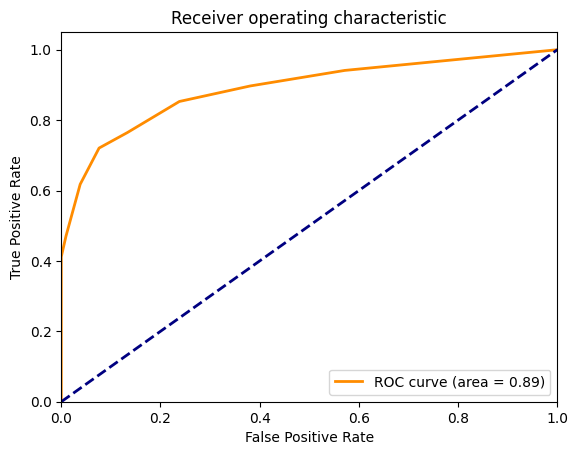

min bootstrapping aucroc:
0.7822510822510822
max bootstrapping aucroc:
0.9643178410794603
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8886788274190327(0.8302721088435374,0.9383050351288057)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = cbclaff
Sex = both
Hypothesis = 2a

Sex = both in final sample n = 680
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7360029796232218


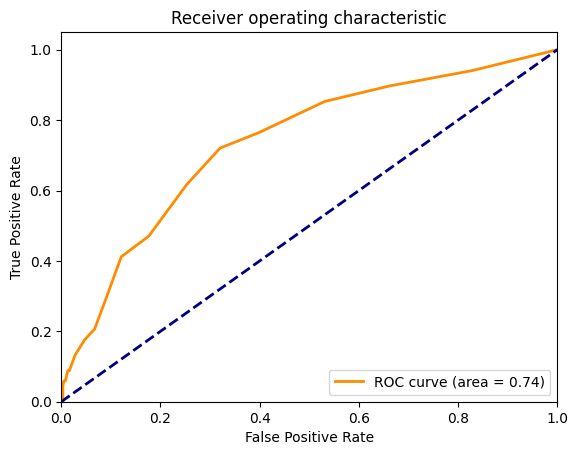

min bootstrapping aucroc:
0.6349878502001144
max bootstrapping aucroc:
0.8332188644688645
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7366304982885501(0.6788870523415977,0.7949889258028793)

...END AUCROC

Measure = cbclaff
Sex = boys
Hypothesis = 1

Sex = boys in final sample n = 102
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8863461538461539


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


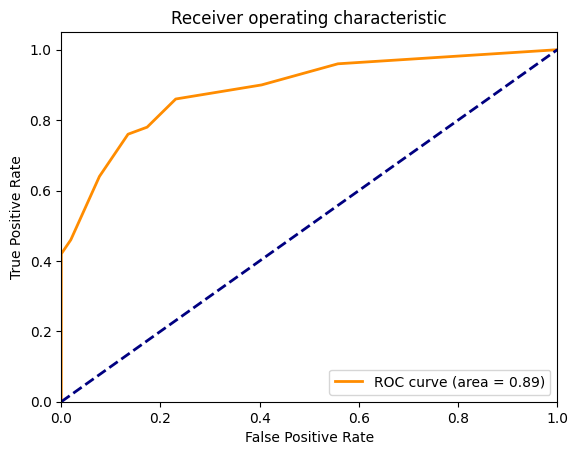

min bootstrapping aucroc:
0.7983934169278997
max bootstrapping aucroc:
0.9613015017327684
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8856390872547281(0.8228174603174602,0.9412783981517134)

...END AUCROC

Measure = cbclaff
Sex = boys
Hypothesis = 2a

Sex = boys in final sample n = 470
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7477142857142858


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


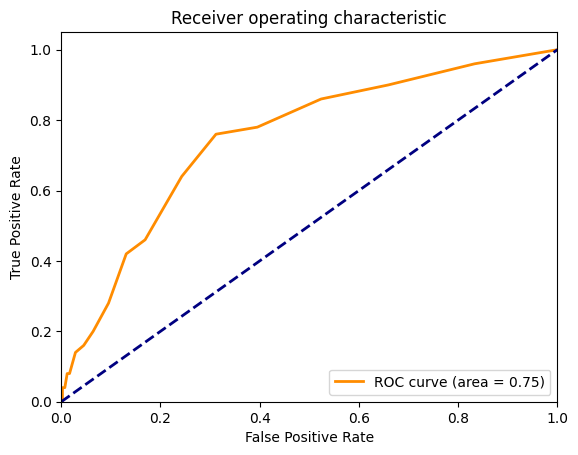

min bootstrapping aucroc:
0.6229461595315253
max bootstrapping aucroc:
0.8626129967593382
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7480144385354908(0.6788773920783266,0.8152372456565141)

...END AUCROC

Measure = cbclaff
Sex = girls
Hypothesis = 1

Sex = girls in final sample n = 71
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8694968553459119


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


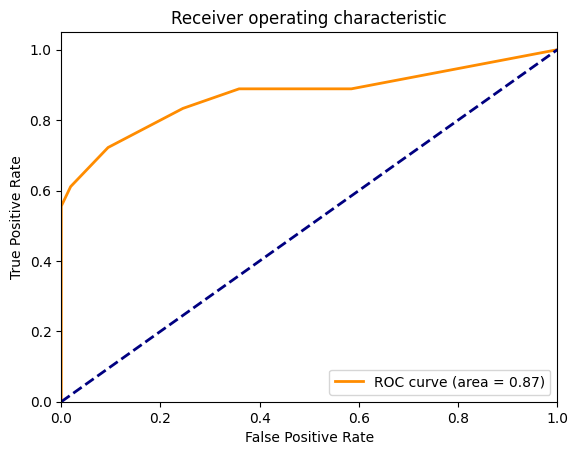

min bootstrapping aucroc:
0.5134408602150538
max bootstrapping aucroc:
0.9965909090909091
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8684420395303515(0.739795918367347,0.9750000000000001)

...END AUCROC

Measure = cbclaff
Sex = girls
Hypothesis = 2a

Sex = girls in final sample n = 200
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7057387057387058


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


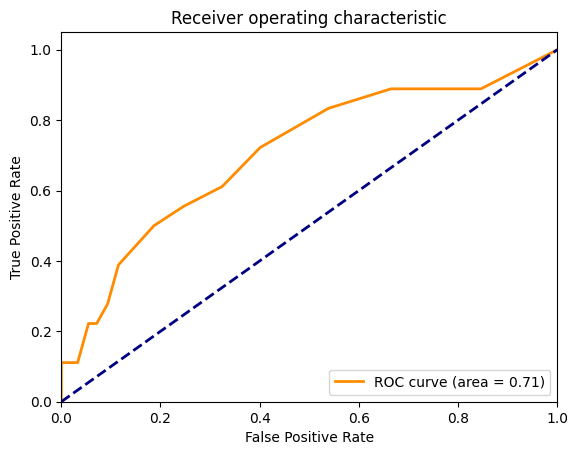

min bootstrapping aucroc:
0.42486486486486486
max bootstrapping aucroc:
0.9209009009009008
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7110364151853009(0.5584622942765904,0.8359375)

...END AUCROC

Measure = anxiousdep
Sex = both
Hypothesis = 1

Sex = both in final sample n = 173
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8487394957983194


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


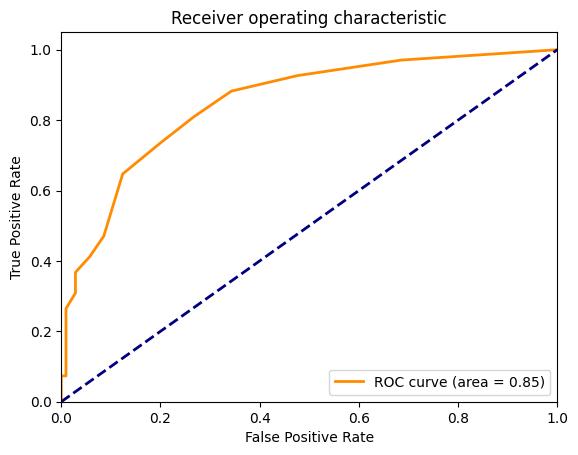

min bootstrapping aucroc:
0.7368777056277056
max bootstrapping aucroc:
0.9498732751337651
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8486238643109874(0.7913165266106443,0.905267629566695)

...END AUCROC

Measure = anxiousdep
Sex = both
Hypothesis = 2a

Sex = both in final sample n = 680
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.6580521914648212


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


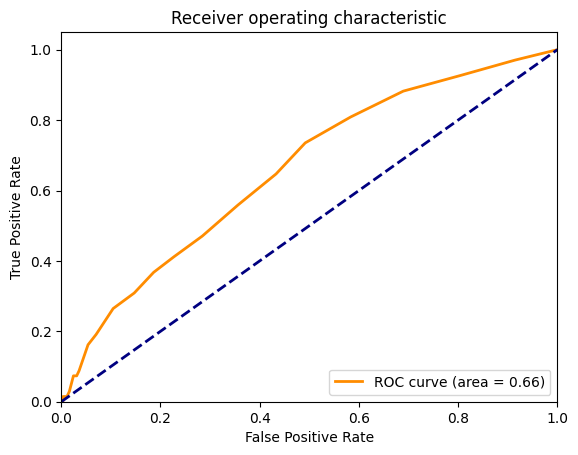

min bootstrapping aucroc:
0.5374824355971897
max bootstrapping aucroc:
0.7678465827490073
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6570707364945328(0.5827533502551926,0.7221370967741936)

...END AUCROC

Measure = anxiousdep
Sex = boys
Hypothesis = 1

Sex = boys in final sample n = 102
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8523076923076923


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


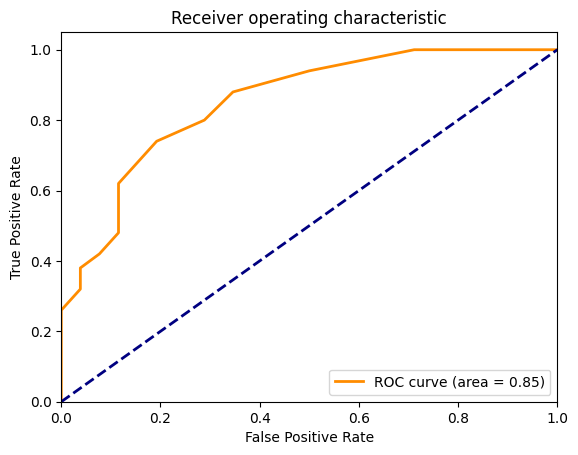

min bootstrapping aucroc:
0.7286549707602339
max bootstrapping aucroc:
0.9521153846153846
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8523583770410136(0.7767857142857143,0.9147727272727273)

...END AUCROC

Measure = anxiousdep
Sex = boys
Hypothesis = 2a

Sex = boys in final sample n = 484
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.6851152073732719


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


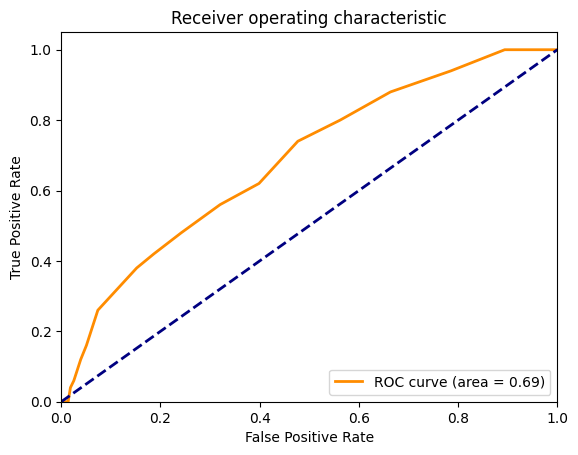

min bootstrapping aucroc:
0.5621136590229312
max bootstrapping aucroc:
0.7850632440476191
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6836310304471943(0.604153199741435,0.7567407024793389)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = anxiousdep
Sex = girls
Hypothesis = 1

Sex = girls in final sample n = 71
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8317610062893082


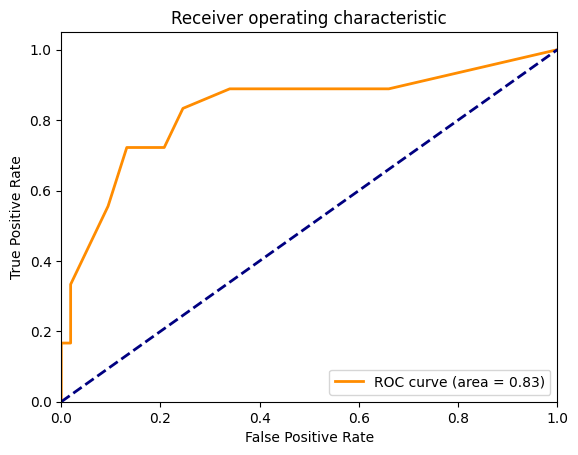

min bootstrapping aucroc:
0.5593681917211328
max bootstrapping aucroc:
0.9711328976034859
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8310363613403801(0.6911764705882353,0.9392156862745098)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = anxiousdep
Sex = girls
Hypothesis = 2a

Sex = girls in final sample n = 187
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.6305062458908612


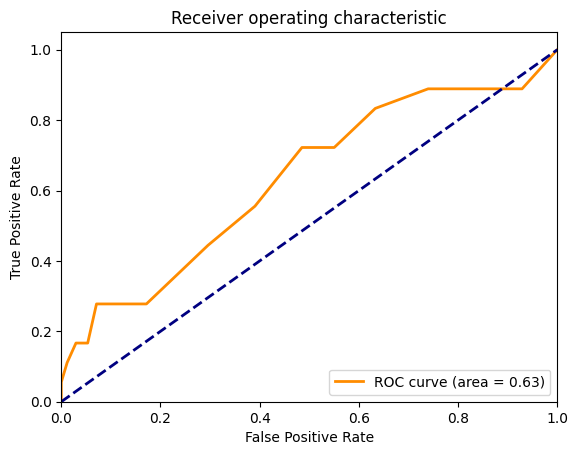

min bootstrapping aucroc:
0.3625103220478943
max bootstrapping aucroc:
0.8600206611570248
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.6341235723730065(0.4851796407185629,0.7722431077694235)

...END AUCROC

Measure = withdrawndep
Sex = both
Hypothesis = 1

Sex = both in final sample n = 173
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8840336134453781


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


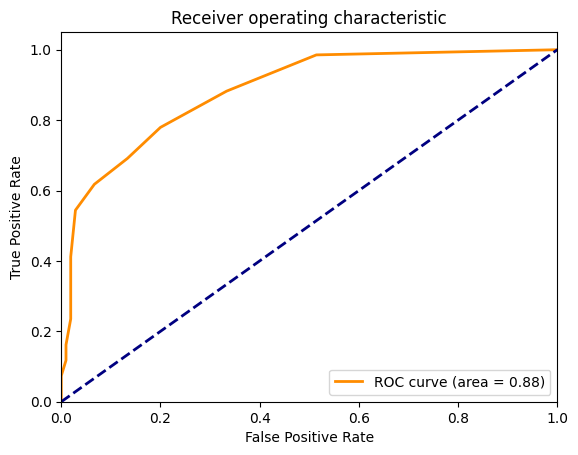

min bootstrapping aucroc:
0.7922077922077921
max bootstrapping aucroc:
0.9537114845938376
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.883597163293737(0.8286835222319093,0.9293197278911565)

...END AUCROC

Measure = withdrawndep
Sex = both
Hypothesis = 2a

Sex = both in final sample n = 680
positive both in final sample n = 68
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7689350249903883


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


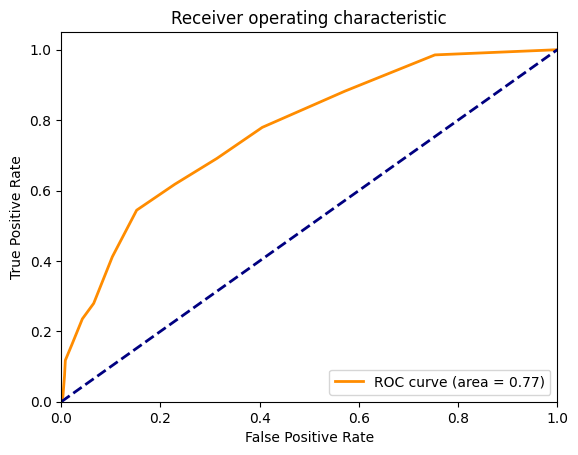

min bootstrapping aucroc:
0.6587992086038961
max bootstrapping aucroc:
0.8880478662053057
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7675373066919936(0.7025931928687196,0.8246815951560705)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = withdrawndep
Sex = boys
Hypothesis = 1

Sex = boys in final sample n = 102
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8769230769230769


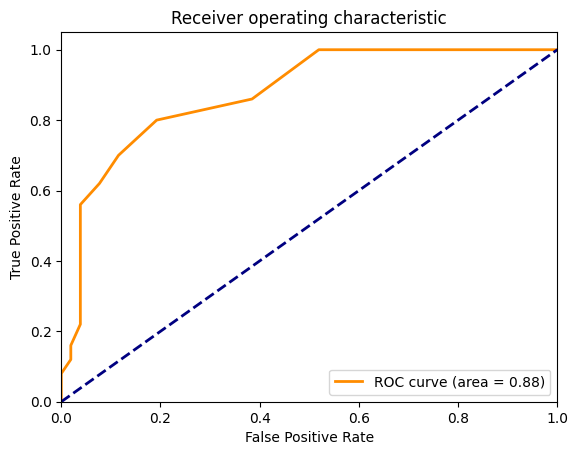

min bootstrapping aucroc:
0.7835964574509049
max bootstrapping aucroc:
0.9651520985752793
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.878010828546762(0.8109356950327301,0.9390384615384616)

...END AUCROC

Measure = withdrawndep
Sex = boys
Hypothesis = 2a

Sex = boys in final sample n = 472
positive boys in final sample n = 50
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7693364928909953


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


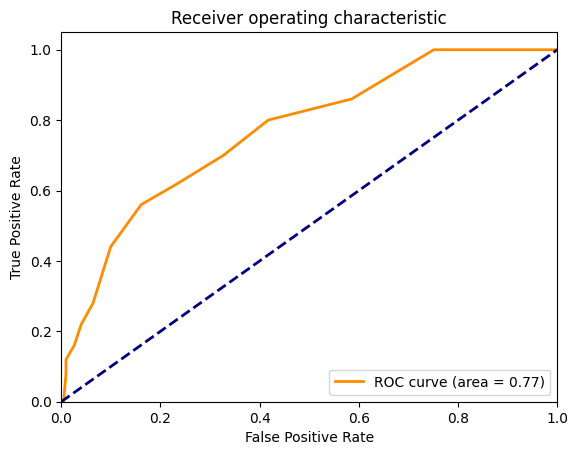

min bootstrapping aucroc:
0.6482175383814728
max bootstrapping aucroc:
0.8756635071090048
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.7674610854926145(0.7039835164835164,0.8348503236245955)

...END AUCROC


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)



Measure = withdrawndep
Sex = girls
Hypothesis = 1

Sex = girls in final sample n = 71
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.8820754716981132


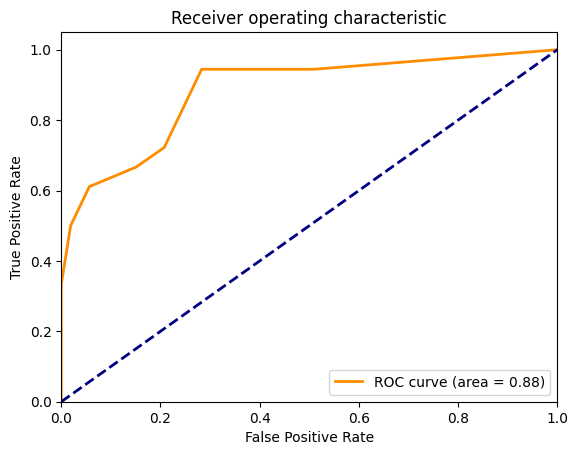

min bootstrapping aucroc:
0.6714285714285715
max bootstrapping aucroc:
0.9825757575757575
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.8828635136749514(0.7744318181818182,0.96684350132626)

...END AUCROC

Measure = withdrawndep
Sex = girls
Hypothesis = 2a

Sex = girls in final sample n = 215
positive girls in final sample n = 18
BEGIN AUCROC...

Single AUCROC score without bootstrapping:
0.7272983643542018


/var/folders/7l/34y2s3yx5q77_c0h8j6s32gc0000gs/T/ipykernel_52535/1571086051.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


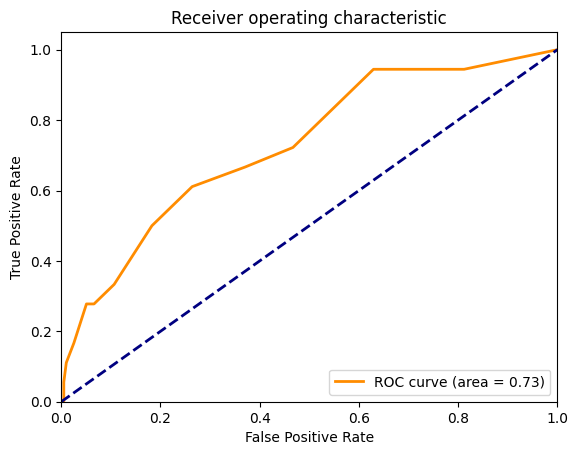

min bootstrapping aucroc:
0.5441736481340442
max bootstrapping aucroc:
0.8905809362662154
p_onesided = 0
p_twosided = 0
boots_mean_AUCROC =
0.727713407066252(0.6010362694300518,0.8473618090452261)

...END AUCROC

FINISH ALL


In [91]:
for measure in ['cbclaff', 'anxiousdep', 'withdrawndep']:
    for sex in ['both', 'boys', 'girls']:
        for hypothesis in ['1', '2a']:
            mydata = load_all_data(path_to_consensusfile=path_to_consensusfile,
                                   path_to_demosfile=path_to_demosfile,
                                   path_to_cbclfile=path_to_cbclfile,
                                   hypothesis=hypothesis,
                                   measure=measure,
                                   sex=sex,
                                   do_print=False)
            fig_file_name = 'HBN_'+measure+'_'+hypothesis+'_'+sex
            y_true,y_measure = run_aucroc_and_plot(mydata, 
                                                    path_to_save_plots='../plotting/plot_data/', 
                                                    name_to_save=fig_file_name, 
                                                    mymeasure = measure, 
                                                    hypothesis = hypothesis,
                                                    nboots=100, 
                                                    target_auc=0.8)
print('\nFINISH ALL')